In [1]:
import numpy as np
import jax.numpy as jnp
from jax import nn, jacfwd, jit, vmap, lax, random
from jax.scipy.stats.norm import cdf, pdf
from functools import partial
import time

from scipy.stats import linregress
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':2,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)

In [2]:
import numpy as np
import jax.numpy as jnp
from jax import nn, jacfwd, jacrev, jit, vmap, lax, random
from functools import partial
import time

# import scipy's optimizer
from scipy.optimize import minimize

# import matrix math functions
from linalg import *


class FFNN():

    def __init__(self, n_inputs, n_hidden, n_outputs, param_0=.2, rng_key=123):

        # set rng key
        self.rng_key = random.PRNGKey(rng_key)

        # store dimensions
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs

        # bounds on initial parameter guess
        self.param_0 = param_0

        # determine shapes of weights/biases = [Wih, bih, Who, bho]
        self.shapes = [[n_hidden, n_inputs], [n_hidden], [n_outputs, n_hidden], [n_outputs]]
        self.k_params = []
        self.n_params = 0
        for shape in self.shapes:
            self.k_params.append(self.n_params)
            self.n_params += np.prod(shape)
        self.k_params.append(self.n_params)
            
        # initialize parameters
        self.params = np.zeros(self.n_params)
        for k1,k2,shape in zip(self.k_params, self.k_params[1:], self.shapes):
            if len(shape)>1:
                stdv = 1/np.sqrt(shape[-1])
            # self.params[k1:k2] = random.uniform(self.rng_key, shape=(k2 - k1,),
            #                                     minval=-self.param_0, maxval=self.param_0)
            self.params[k1:k2] = stdv*random.normal(self.rng_key, shape=(k2-k1,))

        # initialize hyper-parameters
        self.a = 1e-4
        self.b = 1e-4

        # initialize covariance
        self.Ainv = None

        ### define jit compiled functions ###

        # batch prediction
        self.forward_batch = jit(vmap(self.forward, (None, 0)))

        # jit compile gradient w.r.t. params
        self.Gi = jit(jacfwd(self.forward))
        self.G = jit(jacfwd(self.forward_batch))

        # jit compile function to compute gradient of loss w.r.t. parameters
        self.compute_grad_NLL = jit(jacrev(self.compute_NLL))

    # reshape parameters into weight matrices and bias vectors
    def reshape(self, params):
        # params is a vector = [Wih, bih, Who, bho]
        return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
                zip(self.k_params, self.k_params[1:], self.shapes)]

    # per-sample prediction
    @partial(jit, static_argnums=0)
    def forward(self, params, sample):
        # reshape params
        Wih, bih, Who, bho = self.reshape(params)

        # hidden layer
        h = nn.tanh(Wih @ sample + bih)

        # output
        out = Who @ h + bho

        return out

    # estimate posterior parameter distribution
    def fit(self, X, Y, evd_tol=1e-3, nlp_tol=None, alpha_0=1e-5, alpha_1=.1, patience=1, max_fails=3):

        # estimate parameters using gradient descent
        self.itr = 0
        passes = 0
        fails = 0
        convergence = np.inf
        previdence = -np.inf

        # init convergence status
        converged = False

        # initialize hyper parameters
        self.init_hypers(X, Y, alpha_0)

        while not converged:
            # update Alpha and Beta hyper-parameters
            if self.itr > 0: self.update_hypers(X, Y)

            # fit using updated Alpha and Beta
            self.res = minimize(fun=self.objective,
                                jac=self.jacobian,
                                hess=self.hessian,
                                x0=self.params,
                                args=(X, Y,),
                                tol=nlp_tol,
                                method='Newton-CG') # callback=self.callback)
            self.params = self.res.x
            self.loss = self.res.fun

            # update parameter precision matrix (Hessian)
            # print("Updating precision...")
            # if self.itr == 0:
            #     self.alpha = alpha_1 * jnp.ones_like(self.params)
            self.update_precision(X, Y)

            # update evidence
            self.update_evidence()
            # print("Evidence {:.3f}".format(self.evidence))

            # check convergence
            convergence = np.abs(previdence - self.evidence) / np.max([1., np.abs(self.evidence)])

            # update pass count
            if convergence < evd_tol:
                passes += 1
                # print("Pass count ", passes)
            else:
                passes = 0

            # increment fails if convergence is negative
            if self.evidence < previdence:
                fails += 1
                # print("Fail count ", fails)

            # finally compute covariance (Hessian inverse)
            self.update_covariance(X, Y)

            # determine whether algorithm has converged
            if passes >= patience:
                converged = True

            # update evidence
            previdence = np.copy(self.evidence)
            self.itr += 1

    def callback(self, xk, res=None):
        print("Loss: {:.3f}, Residuals: {:.3f}".format(self.loss, self.residuals))
        return True

    # function to compute NLL loss function
    # @partial(jit, static_argnums=(0,))
    def compute_NLL(self, params, X, Y, Beta):
        outputs = self.forward_batch(params, X)
        error = jnp.nan_to_num(outputs - Y)
        self.residuals = jnp.sum(error)/X.shape[0]
        return jnp.einsum('nk,kl,nl->', error, Beta, error) / 2.

    # define objective function
    def objective(self, params, X, Y):
        # init loss with parameter penalty
        self.loss = jnp.dot(self.alpha * params, params) / 2.

        # forward pass
        self.loss += self.compute_NLL(params, X, Y, self.Beta)

        return self.loss

    # define function to compute gradient of loss w.r.t. parameters
    def jacobian(self, params, X, Y):

        # gradient of -log prior
        g = self.alpha * params

        # gradient of -log likelihood
        g += self.compute_grad_NLL(params, X, Y, self.Beta)

        # return gradient of -log posterior
        return g

    # define function to compute approximate Hessian
    def hessian(self, params, X, Y):
        # init w/ hessian of -log(prior)
        A = jnp.diag(self.alpha)

        # outer product approximation of Hessian:

        # Compute gradient of model output w.r.t. parameters
        G = self.G(params, X)

        # update Hessian
        A += A_next(G, self.Beta)

        return (A + A.T)/2.

    # update hyper-parameters alpha and Beta
    def init_hypers(self, X, Y, alpha_0):
        # compute number of independent samples in the data
        self.N = np.sum(~np.isnan(Y), 0)

        # init alpha
        self.alpha = alpha_0 * jnp.ones_like(self.params)

        # update Beta
        self.Beta = jnp.eye(self.n_outputs)
        self.BetaInv = jnp.eye(self.n_outputs)

    # update hyper-parameters alpha and Beta
    def update_hypers(self, X, Y):

        # forward
        outputs = self.forward_batch(self.params, X)
        error = jnp.nan_to_num(outputs - Y)

        # backward
        G = self.G(self.params, X)

        # sum of measurement covariance update
        yCOV = np.sum(error**2, 0) + trace_GGM(G, self.Ainv)
        
        # update alpha
        self.alpha = 1. / (self.params ** 2 + jnp.diag(self.Ainv) + 2. * self.a)
        # alpha = self.n_params / (jnp.sum(self.params**2) + jnp.trace(self.Ainv) + 2.*self.a)
        # self.alpha = alpha*jnp.ones_like(self.params)

        # divide by number of observations
        yCOV = yCOV / self.N

        # update beta
        self.Beta = jnp.diag(1./(yCOV + self.b))
        self.BetaInv = jnp.diag(yCOV)

    # compute precision matrix
    def update_precision(self, X, Y):

        # compute inverse precision (covariance Matrix)
        A = np.diag(self.alpha)

        # update A
        G = self.G(self.params, X)
        A += A_next(G, self.Beta)

        # make sure that matrices are symmetric and positive definite
        self.A, _ = make_pos_def((A + A.T)/2., self.alpha)

    # compute covariance matrix
    def update_covariance(self, X, Y):

        ### fast / approximate method: ###
        # self.Ainv, _ = make_pos_def(compute_Ainv(self.A), jnp.ones(self.n_params))

        # compute inverse precision (covariance Matrix)
        self.Ainv = np.diag(1./self.alpha)

        # update Ainv
        G = self.G(self.params, X)
        for Gi in G:
            self.Ainv -= Ainv_next(Gi, self.Ainv, self.BetaInv) 

        # make sure Ainv is positive definite
        self.Ainv, _ = make_pos_def((self.Ainv + self.Ainv.T)/2., jnp.ones_like(self.alpha))

    # compute the log marginal likelihood
    def update_evidence(self):
        # compute evidence
        self.evidence = 1 / 2 * np.sum(self.N*np.log(np.diag(self.Beta))) + \
                        1 / 2 * np.nansum(np.log(self.alpha)) - \
                        1 / 2 * log_det(self.A) - self.loss

    # function to predict mean of outcomes
    def predict_point(self, X):
        # make point predictions
        preds = self.forward_batch(self.params, X)

        return preds
        
    # function to predict mean of outcomes
    def predict_point_params(self, X, params):
        # make point predictions
        preds = self.forward_batch(params, X)

        return preds

    # function to predict mean and stdv of outcomes
    def predict(self, X):

        # function to get diagonal of a tensor
        get_diag = vmap(jnp.diag, (0,))

        # point estimates
        preds = np.array(self.predict_point(X))

        # compute sensitivities
        G = self.G(self.params, X)

        # compute covariances
        COV = np.array(compute_predCOV(self.BetaInv, G, self.Ainv))

        # pull out standard deviations
        stdvs = np.sqrt(get_diag(COV))

        return preds, stdvs

    # function to predict mean and stdv of outcomes given updated covariance
    def conditional_predict(self, X, Ainv):

        # function to get diagonal of a tensor
        get_diag = vmap(jnp.diag, (0,))

        # point estimates
        preds = self.predict_point(X)

        # compute sensitivities
        G = self.G(self.params, X)

        # compute covariances
        COV = compute_epistemic_COV(G, Ainv)

        # pull out standard deviations
        stdvs = jnp.sqrt(get_diag(COV))

        return preds, stdvs
    
    # function to predict variance at X given precision A
    def conditioned_stdv(self, X, Ainv):

        # compute sensitivities
        G = self.G(self.params, X)

        # compute updated *epistemic* prediction covariance
        COV = np.einsum("nki,ij,nlj->nkl", G, Ainv, G) # + self.BetaInv

        # pull out standard deviations
        get_diag = vmap(jnp.diag, (0,))
        stdvs = np.sqrt(get_diag(COV))

        return stdvs    

    # return indeces of optimal samples
    def search(self, data, objective, N, max_reps=3, batch_size=512, exploit=True):

        # determine number of samples to search over
        n_samples = data.shape[0]
        batch_size = min([n_samples, batch_size])

        # make predictions once
        all_preds  = []
        for batch_inds in np.array_split(np.arange(n_samples), n_samples//batch_size):
            # make predictions on data
            all_preds.append(self.forward_batch(self.params, data[batch_inds]))
        
        # compute objective (f: R^[n_t, n_o, w_exp] -> R) in batches
        objective_batch = jit(vmap(lambda pred, stdv: objective(pred, stdv), (0,0)))

        # initialize conditioned parameter covariance
        Ainv_q = jnp.copy(self.Ainv)

        # search for new experiments until find N
        best_experiments = []
        while len(best_experiments) < N:

            # compute utilities in batches to avoid memory problems
            utilities = []
            for preds, batch_inds in zip(all_preds, np.array_split(np.arange(n_samples), n_samples//batch_size)):
                stdvs = self.conditioned_stdv(data[batch_inds], Ainv_q)
                if exploit:
                    utilities.append(objective_batch(preds, stdvs))
                else:
                    utilities.append(stdvs)
            utilities = jnp.concatenate(utilities)
            # print("Top 5 utilities: ", jnp.sort(utilities)[::-1][:5])
            
            # pick an experiment
            # print(f"Picked experiment {len(best_experiments)} out of {N}")
            exp = np.argmax(utilities)

            # add experiment to the list 
            if sum(np.in1d(best_experiments, exp)) < max_reps:
                best_experiments += [exp.item()]

                # compute sensitivity to sample
                Gi = self.Gi(self.params, data[exp])

                # update conditioned parameter covariance
                Ainv_q -= Ainv_next(Gi, Ainv_q, self.BetaInv)
            elif exploit:
                print("Max replicates exceeded, switching to pure exploration")
                exploit=False
            else:
                print("Max exploration replicates exceeded, terminating")
                return best_experiments

        return np.sort(best_experiments)

In [3]:
# COSINES
def f(x):
    x, y = x
    u = 1.6*x - .5
    v = 1.6*y - .5
    return 1 - (u**2 + v**2 - .3*np.cos(3*np.pi*u) - .3*np.cos(3*np.pi*v))

# ROSENBROCK
# def f(x):
#     x, y = x
#     return 10 - 100*(y - x**2)**2 - (1-x)**2

def generate_data(X, noise=0.):
    Nsamples = X.shape[0]
    Y = np.zeros([Nsamples, 1])
    
    for i in range(Nsamples):
        # add some standard Gaussian noise to Y
        Y[i] = f(X[i]) + noise*np.random.randn()

    return Y

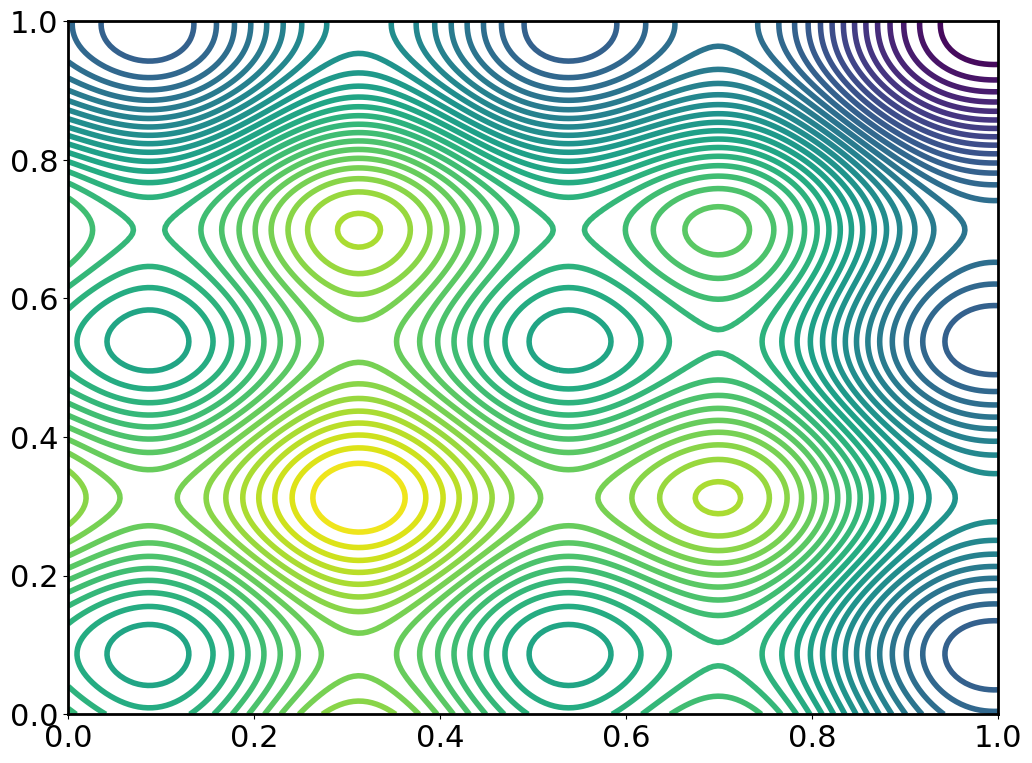

In [4]:
# define design space
n_grid = 200
F_grid = np.zeros([n_grid, n_grid])
X = np.linspace(0, 1, n_grid)
Y = np.linspace(0, 1, n_grid)
Xmesh,Ymesh = np.meshgrid(X,Y)

# test datapoints
X_design = np.stack([Xmesh.ravel(), Ymesh.ravel()]).T
Y_design = generate_data(X_design)

for i, xi in enumerate(X):
    for j, yj in enumerate(Y):
        F_grid[j,i] = f([xi,yj])
        
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(np.min(F_grid), np.max(F_grid), n_grid//5))   
plt.savefig("Results/objective.pdf")
plt.show()

In [5]:
# define number of test points
n_init = 5
n_test = 5
n_cycles = 9
n_hidden = 16
noise = .05 # .05 = ~10% of variation in response without noise

# train data points
X_train = np.random.uniform(size=[n_init, 2])
Y_train = generate_data(X_train) #, noise=noise)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


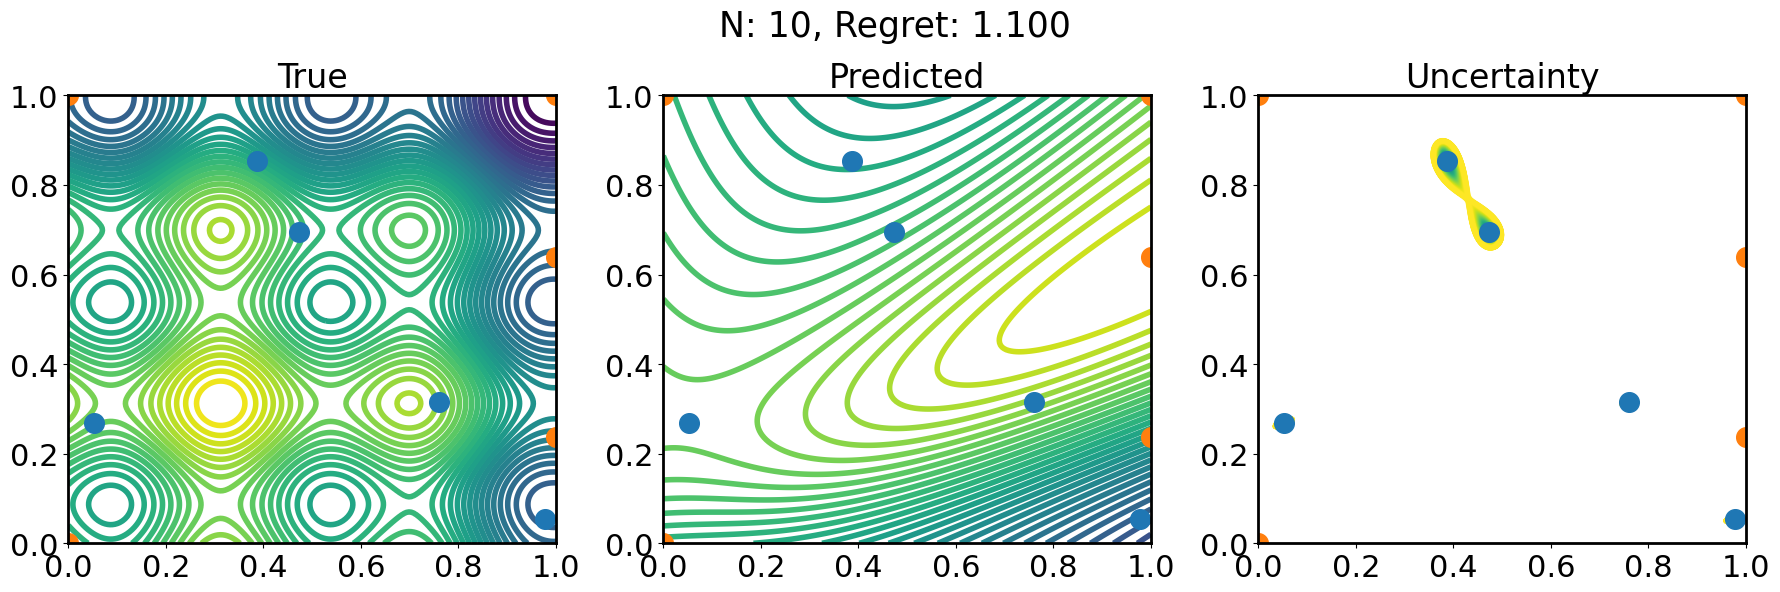

In [6]:
stdv_levels = np.exp(.15*np.linspace(0, 20, n_grid//5)) -1 

for i in range(n_cycles):
    # scale data
    Xscaler = StandardScaler().fit(X_train)
    X_train = Xscaler.transform(X_train)
    X_test  = Xscaler.transform(X_design)

    Yscaler = StandardScaler().fit(np.vstack(Y_train))
    Y_train = Yscaler.transform(np.vstack(Y_train))
    Y_test  = Yscaler.transform(np.vstack(Y_design))

    n_inputs = X_train.shape[1]
    n_outputs = Y_train.shape[1]
    
    # Fit NN
    ffnn = FFNN(n_inputs, n_hidden, n_outputs)
    t0 = time.time()
    ffnn.fit(X_train, Y_train)

    # Design next experiment

    # Expected improvement objective
    fstar = np.max(Y_train)
    def objective(pred, stdv):
        improvement = pred - fstar
        Z = improvement/stdv
        return improvement*cdf(Z) + stdv*pdf(Z)

    # search for new data points
    design_inds = ffnn.search(X_test, objective, n_test)
    X_old = Xscaler.inverse_transform(X_train) 
    Y_old = Yscaler.inverse_transform(Y_train)
    X_new = X_design[design_inds]
    Y_new = Y_design[design_inds]

    # plot model approximation of objective and uncertainty
    Y, Y_stdv = ffnn.predict(X_test)

    F_pred = np.reshape(Yscaler.inverse_transform(Y), [n_grid, n_grid])
    F_stdv = np.reshape(Yscaler.scale_*Y_stdv, [n_grid, n_grid])
    Y_min = np.min(Y_design)
    Y_max = np.max(Y_design)

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("True")

    plt.subplot(132)
    plt.contour(Xmesh, Ymesh, F_pred, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("Predicted")

    plt.subplot(133)
    # plt.contour(Xmesh, Ymesh, F_stdv, levels=stdv_levels, zorder=0)
    plt.contour(Xmesh, Ymesh, F_stdv, levels=np.linspace(0., 5*Y_max, n_grid), zorder=0)
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("Uncertainty")

    # compute regret
    regret = np.max(Y_design) - np.max(Y_new)
    plt.suptitle("N: {:.0f}, Regret: {:.3f}".format(X_train.shape[0]+X_new.shape[0], regret), fontsize=25)
    plt.tight_layout()
    plt.savefig(f"Results/Cosines_DTL_{i}.pdf")
    plt.show()
    break

    # update training data with new design (AVERAGE OVER REPLICATES)
    
    # matrix to average over replicate samples
    unique_designs, counts = np.unique(design_inds, return_counts=True)
    C = np.zeros([len(unique_designs), len(design_inds)])
    k = 0
    for i,c in enumerate(counts):
        C[i,k:k+c] = 1.
        k += c

    # sample several replicates of response
    Y_new = generate_data(X_new, noise=noise)

    # average over replicates
    X_new = np.einsum('nm,mk,n->nk', C, X_new, 1./counts) 
    Y_new = np.einsum('nm,mk,n->nk', C, Y_new, 1./counts) 
    
    # update training data with new data 
    X_train = np.concatenate((X_old, X_new))
    Y_train = np.concatenate((Y_old, Y_new))

In [16]:
np.mean(Y_stdv)

182.53712